# Imports

In [87]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score , classification_report
from sklearn.manifold import TSNE


import warnings 
warnings.filterwarnings("ignore")

# Data PreProcessing

In [2]:
df = pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
print(df.shape)
df.info()

(303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [5]:
duplicate = df.duplicated().sum()
if duplicate:
    print(duplicate)
    df.drop_duplicates(inplace = True)
    print("Cleared")
else:
    print("No duplicates")

1
Cleared


In [6]:
for i in df.columns:
    print(f"Range of col {i}: Max: {df[i].max()}, Min: {df[i].min()}\n{'*'*100}\n")

Range of col age: Max: 77, Min: 29
****************************************************************************************************

Range of col sex: Max: 1, Min: 0
****************************************************************************************************

Range of col cp: Max: 3, Min: 0
****************************************************************************************************

Range of col trtbps: Max: 200, Min: 94
****************************************************************************************************

Range of col chol: Max: 564, Min: 126
****************************************************************************************************

Range of col fbs: Max: 1, Min: 0
****************************************************************************************************

Range of col restecg: Max: 2, Min: 0
****************************************************************************************************

Range of col thalachh: Max: 202, Min: 7

In [7]:
continus_cols = [i for i in df.columns if len(Counter(df[i]))>5]
continus_cols

['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

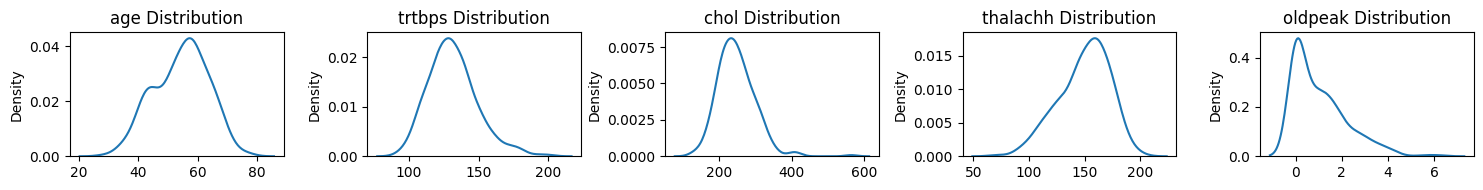

In [8]:
fig, ax = plt.subplots(1, 5, figsize = (15, 2))

ax = ax.flatten()
for i, column in enumerate(continus_cols):
    sns.kdeplot(df[column], ax=ax[i])    
    ax[i].set_title(f'{column} Distribution')
    ax[i].set_xlabel(None)
    

plt.tight_layout()
plt.show()

In [9]:
df['age'] = pd.cut(df['age'], bins = 5, labels = False, right = False)
df['age'] = df['age'].astype(int)

In [10]:
df['trtbps'] = pd.cut(df['trtbps'], bins = 6, labels = False, right = False)
df['trtbps'] = df['trtbps'].astype(int)

In [11]:
df['chol'] = pd.cut(df['chol'], bins = 5, labels = False, right = False)
df['chol'] = df['chol'].astype(int)

In [12]:
df['thalachh'] = pd.cut(df['thalachh'], bins = 5, labels = False, right = False)
df['thalachh'] = df['thalachh'].astype(int)

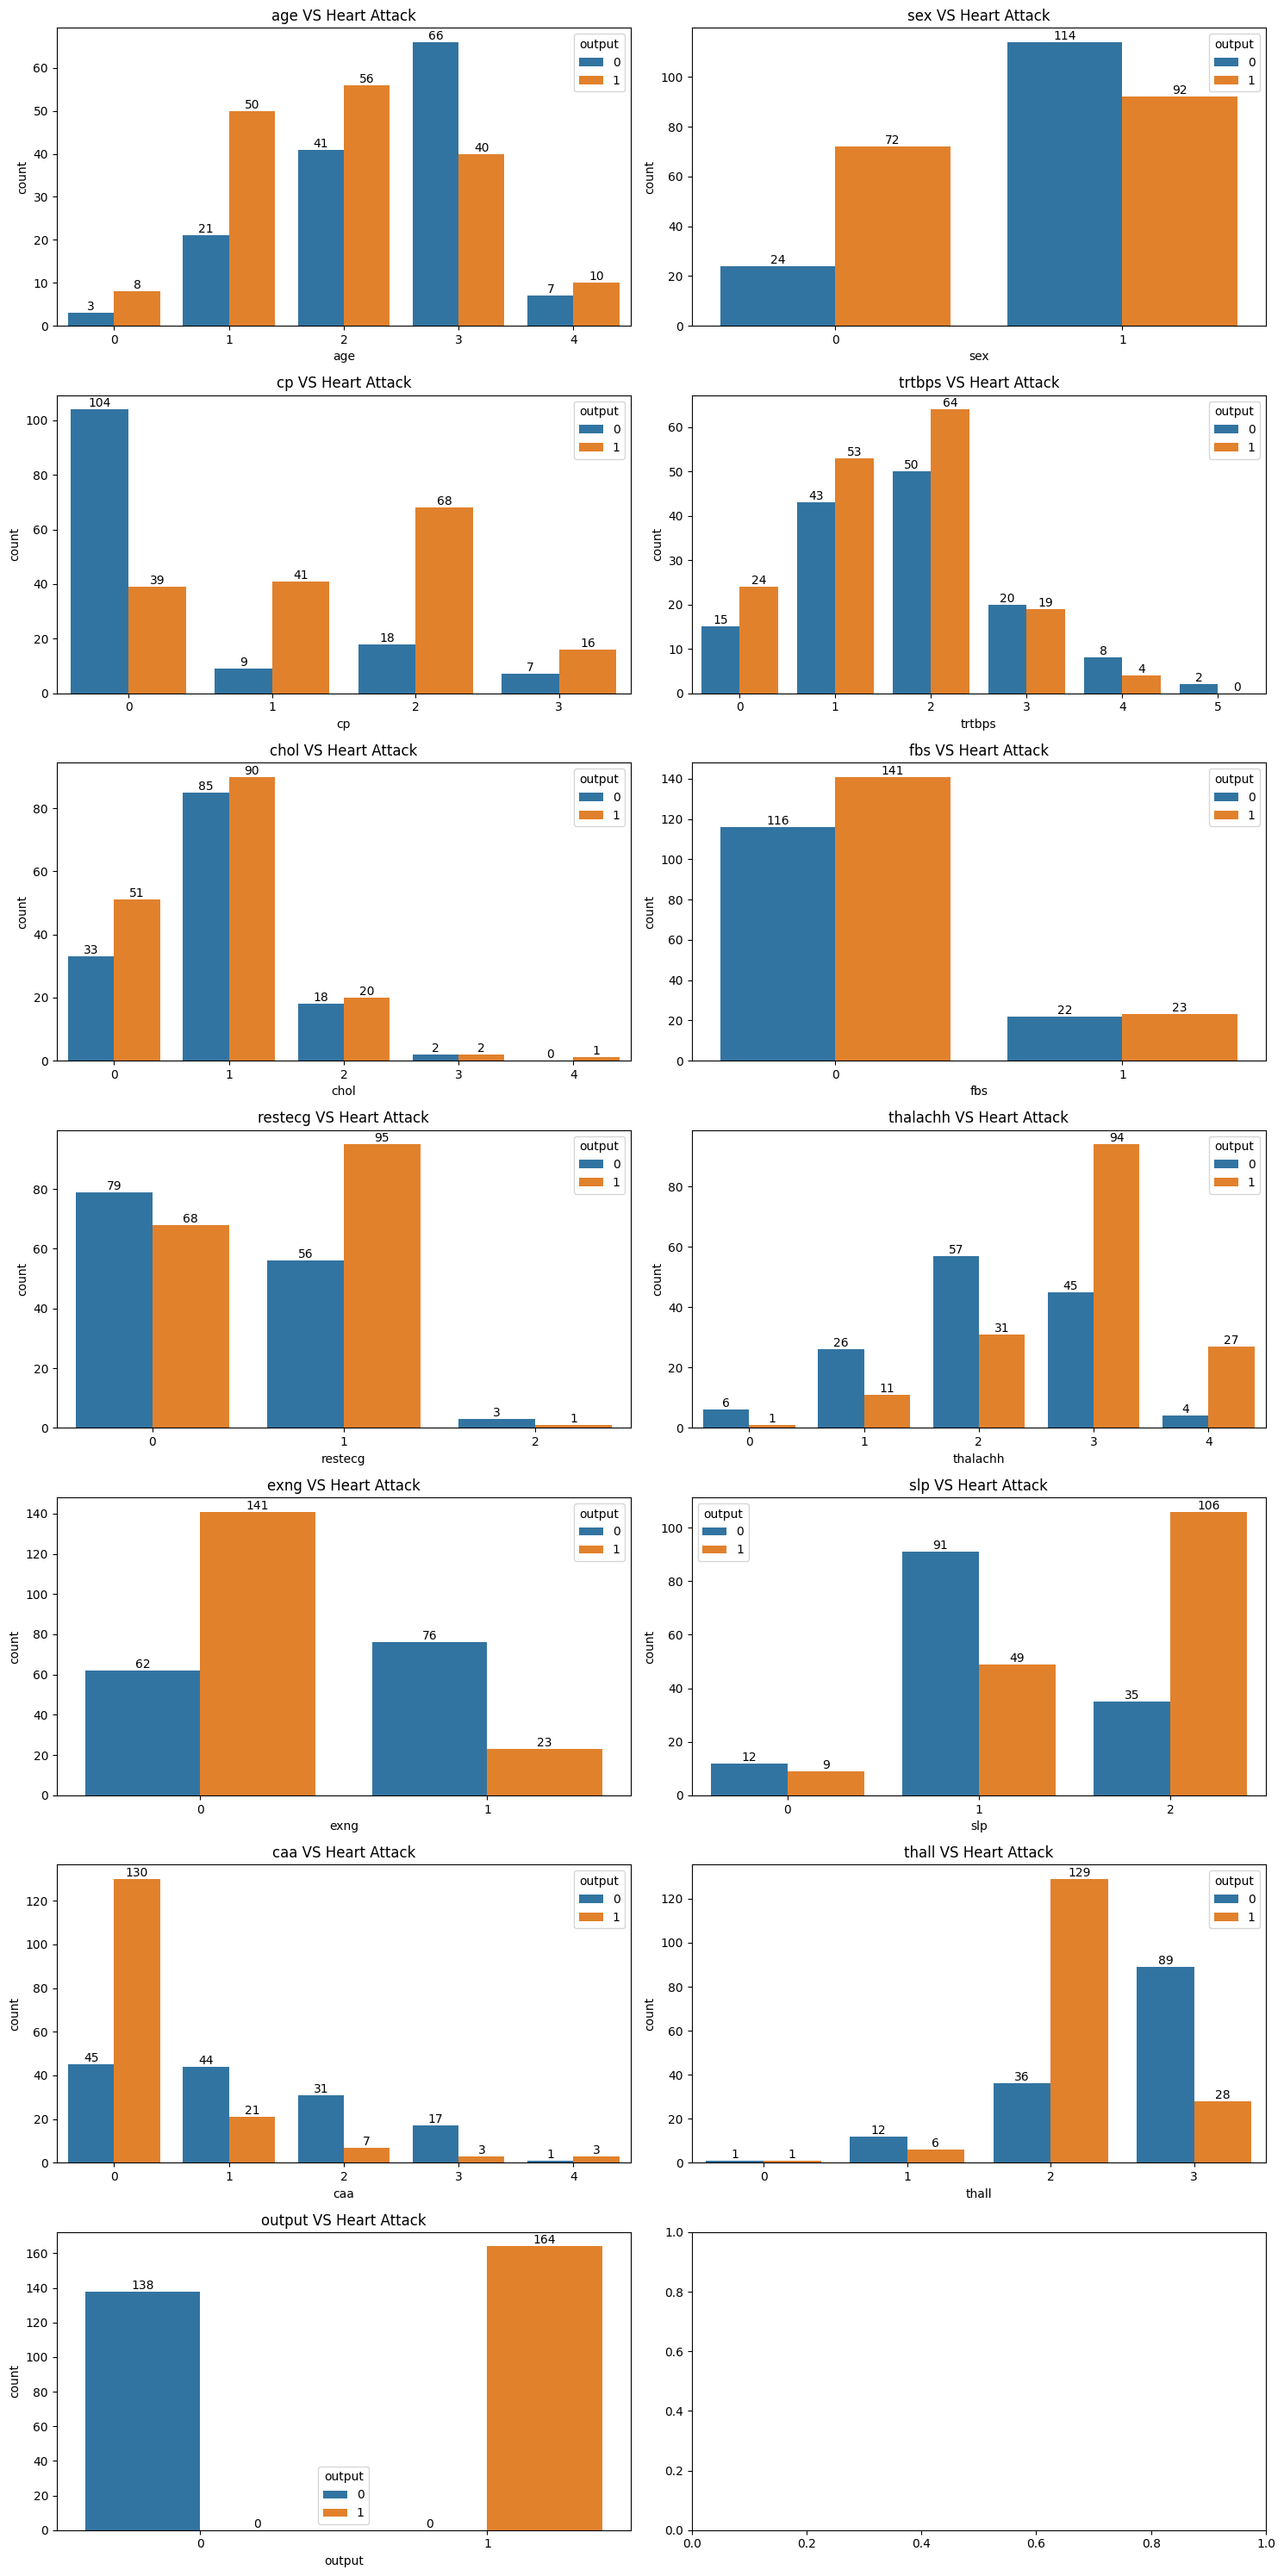

In [13]:
num_rows = [i for i in df.columns if len(Counter(df[i]))<=6]
cols = len(num_rows)

fig, axes = plt.subplots(int(cols/2)+1, 2, figsize=(15, 30))

axes = axes.flatten()

for i, column in enumerate(num_rows):
    if len(Counter(df[column]))<=6:
        ax = sns.countplot(data = df, x = column, hue = 'output', ax = axes[i])
        [ax.bar_label(i) for i in ax.containers];
        axes[i].set_title(column + " VS Heart Attack")
        
plt.tight_layout()
plt.show()

### Exang VS CP

### الذبحة الصدرية  VS نوع الم الصدر

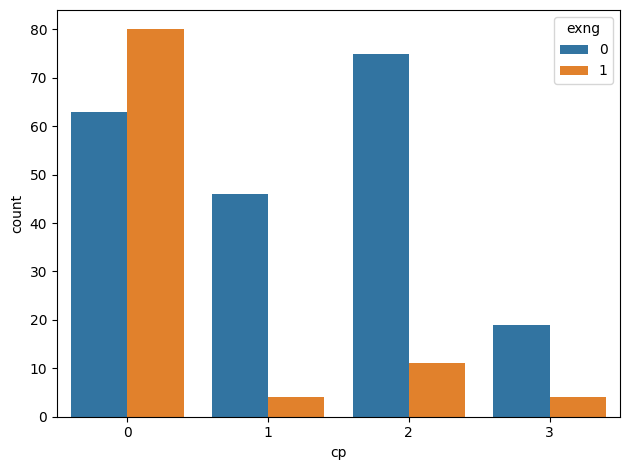

In [14]:
sns.countplot(data = df, x = 'cp', hue = 'exng')

plt.tight_layout()
plt.show()

### FPS VS CHOL

### السكر vs الكوليسترول

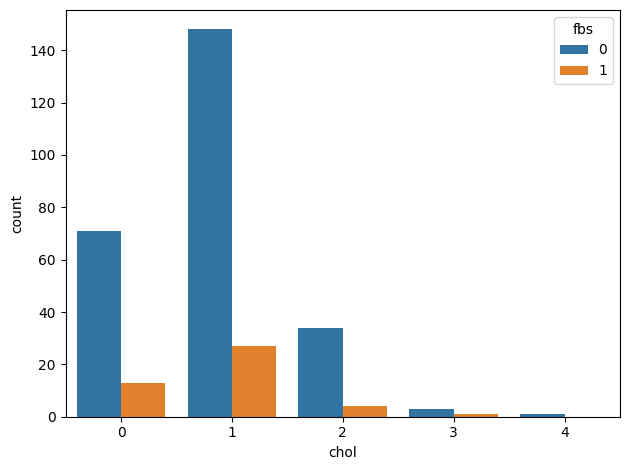

In [15]:
sns.countplot(data = df, x = 'chol', hue = 'fbs')

plt.tight_layout()
plt.show()


### trtbps vs thalachh

### َضغط الدم  VS معدل ضربات القلب

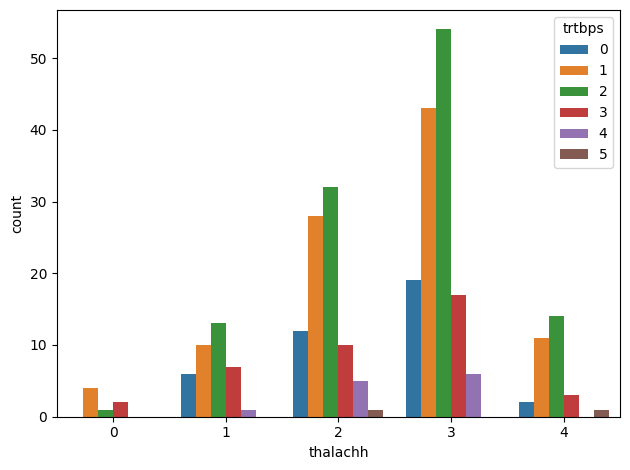

In [16]:
sns.countplot(data = df, x = 'thalachh', hue = 'trtbps')

plt.tight_layout()
plt.show()

In [17]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

for i in df.columns:
    outliers = detect_outliers_iqr(df[i])
    print(f"Outlier count in {i}: {outliers.sum()}\nVariance: {df[i].var()}\n{'*'*100}\n")

Outlier count in age: 0
Variance: 0.9358319948956019
****************************************************************************************************

Outlier count in sex: 0
Variance: 0.2175529691315923
****************************************************************************************************

Outlier count in cp: 0
Variance: 1.0651140788981541
****************************************************************************************************

Outlier count in trtbps: 14
Variance: 1.0647620514400122
****************************************************************************************************

Outlier count in chol: 5
Variance: 0.4748960418912675
****************************************************************************************************

Outlier count in fbs: 45
Variance: 0.12722492354403644
****************************************************************************************************

Outlier count in restecg: 0
Variance: 0.2767045829574707
*******

## Data Splitting

In [18]:
y = df['output'].copy()
X = df.copy()
X.drop(columns = 'output' , inplace = True)

In [19]:
print(X.shape)
print(y.shape)

(302, 13)
(302,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Feature Selection

### Genetic Algorithm

In [21]:
def generate_individual(num_features):
    """Generate a binary mask as an individual for feature selection."""
    return [np.random.choice([0, 1]) for _ in range(num_features)]

In [22]:
def fitness(individual, X_train, X_test, y_train, y_test):
    """Evaluate the fitness of an individual using an Random Forest classifier."""
    selected_features = [feature for feature, select in zip(range(len(individual)), individual) if select == 1]
    if not selected_features:
        return 0  # Avoid selecting zero features

    clf = RandomForestClassifier(random_state=43)    
    # Apply selected features to training and testing sets
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    # Reshape if needed
    if len(X_train_selected.shape) == 3:
        X_train_selected = X_train_selected.reshape(X_train_selected.shape[0], -1)
        X_test_selected = X_test_selected.reshape(X_test_selected.shape[0], -1)

    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    return accuracy_score(y_test, y_pred)

In [23]:
def crossover(parent1, parent2):
    """Perform one-point crossover between two parents."""
    crossover_point = np.random.randint(0, len(parent1))
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [24]:
def mutate(individual, mutation_rate):
    """Perform bit-flip mutation."""
    return [bit ^ (np.random.rand() < mutation_rate) for bit in individual]

In [25]:
def genetic_algorithm(X_train, X_test, y_train, y_test, population_size, generations, mutation_rate):
    num_features = X_train.shape[1]

    # Initialization
    population = [generate_individual(num_features) for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness
        fitness_scores = [fitness(individual, X_train, X_test, y_train, y_test) for individual in population]

        # Select individuals for crossover
        selected_indices = np.random.choice(range(population_size), size=population_size, p=fitness_scores / np.sum(fitness_scores))
        selected_population = [population[i] for i in selected_indices]

        # Create next generation through crossover and mutation
        next_generation = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected_population[i], selected_population[i + 1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            next_generation.extend([child1, child2])

        population = next_generation

        # Monitor the best individual in each generation
        best_individual = max(population, key=lambda ind: fitness(ind, X_train, X_test, y_train, y_test))
        print(f"Generation {generation + 1}: Fitness: {fitness(best_individual, X_train, X_test, y_train, y_test)}")

    # Return the best individual (selected features)
    return best_individual

In [26]:
best_features = genetic_algorithm(
    X_train.values, 
    X_test.values, 
    y_train.values, 
    y_test.values, 
    population_size=10, 
    generations=15, 
    mutation_rate=0.01)

print("\nBest Features:", best_features)

Generation 1: Fitness: 0.83
Generation 2: Fitness: 0.81
Generation 3: Fitness: 0.83
Generation 4: Fitness: 0.82
Generation 5: Fitness: 0.81
Generation 6: Fitness: 0.81
Generation 7: Fitness: 0.82
Generation 8: Fitness: 0.82
Generation 9: Fitness: 0.82
Generation 10: Fitness: 0.8
Generation 11: Fitness: 0.8
Generation 12: Fitness: 0.84
Generation 13: Fitness: 0.84
Generation 14: Fitness: 0.84
Generation 15: Fitness: 0.81

Best Features: [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]


In [27]:
selected_features = [df.columns[i] for i in range (len(best_features)) if best_features[i] == 1 ]

selected_features

['sex', 'fbs', 'restecg', 'thalachh', 'exng', 'caa', 'thall']

In [88]:
X = df[selected_features].copy()

# Feature Reduction 

### PCA

In [89]:
class PCA:
    def __init__(self , n_components = None):
        self.n_components = n_components
        self.components = None
        self.df_mean = None
        self.df_std = None
        
    def fit(self , df):
        """
        
         df: An array of shape (n_samples, n_features).

        """
        # Data Standardization 
        self.df_mean = df.mean(axis = 0)
        self.df_std = df.std(axis = 0)
        self.standardized_df = (df - self.df_mean) / self.df_std
        
        # Transpose to calculate Covariance over Featured 
        cov_matrix = np.cov(self.standardized_df.T)
        
    
        eigenValues , eigenVectors = np.linalg.eig(cov_matrix)
    
        # sort Eigen Values in descending order and Save indices  
        sorted_ind = np.argsort(eigenValues)[::-1]
        self.components = eigenVectors[:, sorted_ind[:self.n_components]]
        print(f'Shape of Components is {self.components.shape}')
    def transform (self , df):
        # Data Standardization 
        standardized_df = (df - self.df_mean) / self.df_std
       
        # Project the data into the Eigen Vectors 
        projected_df = np.dot(standardized_df, self.components)
        
        return projected_df
    def inverse_transform (self , df):
        reconstructed_df = np.dot(df , self.components.T) + self.df_mean
        
        return reconstructed_df

        

In [90]:
pca = PCA(n_components=6)

In [91]:
pca.fit(X)

Shape of Components is (7, 6)


In [92]:
X = pca.transform(X)

In [93]:
X.shape

(302, 6)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

# Modeling

### KNN

In [103]:
class KNN:
    def __init__(self, k=None):
        self.k = k
        self.X_train = None
        self.y_train = None
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            distances = [self.euclidean_distance(X_test[i], x) for x in self.X_train]
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = [self.y_train.iloc[idx] for idx in nearest_indices]
            prediction = max(set(nearest_labels), key=nearest_labels.count)
            predictions.append(prediction)
        return predictions

In [104]:
clf = KNN(k = 5)
clf.fit(X_train , y_train)

In [106]:
y_pred = clf.predict(X_test)

In [107]:
print(classification_report(y_pred , y_test))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        27
           1       0.89      0.78      0.83        40

    accuracy                           0.81        67
   macro avg       0.80      0.81      0.80        67
weighted avg       0.82      0.81      0.81        67

